# Imports

In [1]:
import os
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Load Data

In [3]:
# Folder containing the datset
data_dir = 'dataset'

In [4]:
def load_data(filename, data_dir):
    h5f = h5py.File(os.path.join(data_dir, 'processed_data', filename), 'r')
    images = h5f['images'][:]
    h5f.close()
    return images

In [5]:
def load_labels(filename, data_dir):
    h5f = h5py.File(os.path.join(data_dir, 'processed_data', filename), 'r')
    labels = h5f['labels'][:]
    h5f.close()
    return labels

Load training data

In [6]:
train_images = load_data('train_images.h5', data_dir)

In [7]:
train_categories = load_labels('train_categories.h5', data_dir)

Load validation data

In [8]:
val_images = load_data('val_images.h5', data_dir)

In [9]:
val_categories = load_labels('val_categories.h5', data_dir)

Load test data

In [10]:
test_images = load_data('test_images.h5', data_dir)

In [11]:
test_categories = load_labels('test_categories.h5', data_dir)

Load mapping

In [12]:
with open('dataset/coco_raw.pickle', 'rb') as file:
    coco_raw = pickle.load(file)
id_category = coco_raw['id_category']

In [13]:
num_classes = len(id_category)
num_classes

80

In [14]:
num_images_train = train_images.shape[0]
num_images_train

19324

### Display a sample image

person
frisbee


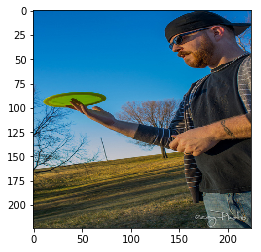

In [15]:
# display image
idx = 10

for category, value in enumerate(train_categories[idx]):
    if value != 0:
        print(id_category[category])

plt.imshow(train_images[idx])
plt.show()

# Define Model

In [16]:
# Download VGG16 model along with the fully-connected layers
model = VGG19(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
# Extract the second last layer which is a fully-connected layer
transfer_layer = model.get_layer('block5_pool')

In [18]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [19]:
# Create the encoder model
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [20]:
# Start a new Keras Sequential model.
image_model = Sequential()

# Add the convolutional part of the VGG19 model from above.
image_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
image_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG19 model has
# recognized in the image.
image_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
# image_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
image_model.add(Dense(num_classes, activation='sigmoid'))

In [21]:
# Set the VGG19 layers to be non-trainable
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [22]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 80)                82000     
Total params: 45,797,520
Trainable params: 25,773,136
Non-trainable params: 20,024,384
_________________________________________________________________


In [23]:
# Compile the model
optimizer = Adam(lr=1e-3)

image_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [24]:
# set model callbacks
path_checkpoint = 'checkpoint.keras'

tb = TensorBoard(log_dir='dataset' + '/tensorboard-logs', histogram_freq=0, write_graph=False)
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks = [tb, checkpoint, early_stop]

# Train Model

In [25]:
# Load previously trained model weights
try:
    image_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [26]:
image_model.fit(
    x=train_images,
    y=train_categories,
    batch_size=128,
    epochs=100,
    callbacks=callbacks,
    validation_data=(val_images, val_categories)
)

Train on 19324 samples, validate on 4589 samples
Epoch 1/100
19200/19324 [============================>.] - ETA: 10s - loss: 0.1405 - binary_accuracy: 0.9749
Epoch 00001: saving model to checkpoint.keras
19324/19324 [==============================] - 2081s 108ms/step - loss: 0.1404 - binary_accuracy: 0.9749 - val_loss: 0.1275 - val_binary_accuracy: 0.9805
Epoch 2/100
19200/19324 [============================>.] - ETA: 10s - loss: 0.1171 - binary_accuracy: 0.9830
Epoch 00002: saving model to checkpoint.keras
19324/19324 [==============================] - 2074s 107ms/step - loss: 0.1169 - binary_accuracy: 0.9830 - val_loss: 0.1306 - val_binary_accuracy: 0.9803
Epoch 3/100
  128/19324 [..............................] - ETA: 27:19 - loss: 0.1095 - binary_accuracy: 0.9860

KeyboardInterrupt: 